For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is its performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [1]:
# Set up data science environment.
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import seaborn as sns
import spacy
import warnings
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.palettes import all_palettes
from bokeh.plotting import figure, show
from collections import Counter
from collections import Iterable
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from mpl_toolkits.mplot3d import Axes3D
from nltk.corpus import inaugural, stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, normalize, Normalizer
from sklearn.tree import DecisionTreeClassifier
from typing import Dict

# Display preferences.
%matplotlib inline
output_notebook()
pd.options.display.float_format = '{:.3f}'.format
pyLDAvis.enable_notebook()
sns.set_style('white')
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='internal gelsd'
)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 

Loading BokehJS ...

# Data Cleaning, Processing, and Language Parsing

In [2]:
# Create lists for files and presidents.
files = ["1789-Washington.txt",
         "1801-Jefferson.txt",
         "1861-Lincoln.txt",
         "1933-Roosevelt.txt",
         "1953-Eisenhower.txt",
         "1961-Kennedy.txt",
         "1981-Reagan.txt",
         "1989-Bush.txt",
         "1993-Clinton.txt",
         "2009-Obama.txt"]

presidents = ["washington",
              "jefferson",
              "lincoln",
              "fdr",
              "eisenhower",
              "kennedy",
              "reagan",
              "ghwbush",
              "clinton",
              "obama"]

# Control to make sure both lists are the same length.
assert len(files) == len(presidents)

In [3]:
# Loop to open files.
docs = []
for file_name, president in zip(files, presidents):
    with open(f'./inaugural/{file_name}') as f:
        doc = f.read()
        docs.append((doc, president))

In [4]:
def text_cleaner(text: str) -> str:
    """Function to strip all characters except letters in words."""
    text = re.sub(r'--', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[\[].*?[\]]", "", text)
    text = re.sub(r"[\<].*?[\>]", "", text)
    text = ' '.join(text.split())
    return text

In [5]:
# Use text_cleaner on the docs, combine them into data frame (clean_docs).
clean_docs = []
for doc, pres in docs:
    clean_doc = text_cleaner(doc)
    clean_docs.append((clean_doc, pres))

In [6]:
# Iterate through each doc and print the first 100 characters for inspection.
for doc, pres in clean_docs:
    print(doc[:100], pres.upper()) 
    print()

Fellow-Citizens of the Senate and of the House of Representatives: Among the vicissitudes incident t WASHINGTON

Friends and Fellow Citizens: Called upon to undertake the duties of the first executive office of ou JEFFERSON

Fellow-Citizens of the United States: In compliance with a custom as old as the Government itself, I LINCOLN

I am certain that my fellow Americans expect that on my induction into the Presidency I will address FDR

My friends, before I begin the expression of those thoughts that I deem appropriate to this moment,  EISENHOWER

Vice President Johnson, Mr. Speaker, Mr. Chief Justice, President Eisenhower, Vice President Nixon,  KENNEDY

Senator Hatfield, Mr. Chief Justice, Mr. President, Vice President Bush, Vice President Mondale, Sen REAGAN

Mr. Chief Justice, Mr. President, Vice President Quayle, Senator Mitchell, Speaker Wright, Senator D GHWBUSH

My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in the CLINTON

My fell

In [7]:
# Find number of characters in all docs.
print(len(clean_doc))

13334


In [8]:
# Define nlp as spacy.
nlp = spacy.load('en')
# Create an empty list for df.
df_list = []


def nlp_text(text_file: str) -> doc:
    """Function that takes a text file and tokenizes it with spacy."""
    return nlp(text_file)


def sentences(doc_nlp: str, speaker: str) -> [str, str]:
    """Function that takes two strings, lemmatizes the first string and 
    returns a list with two strings.
    """
    return [[sent.lemma_, speaker] for sent in doc_nlp.sents]


def sentences_to_df(sents):
    """Function that takes a string and returns a data frame."""
    return pd.DataFrame(sents)


# Calling each function.
for doc, pres in clean_docs:
    parsed = nlp_text(doc)
    sents = sentences(parsed, pres)
    df = sentences_to_df(sents)
    df_list.append(df)

In [9]:
# Combine each sentence data frame into one master data frame.
sent_df = pd.concat([*df_list])

In [10]:
# Rename columns.
sent_df.columns = ['sentence', 'President']

# Check the count of sents per President.
sent_df.President.value_counts()

ghwbush       145
lincoln       139
reagan        130
eisenhower    121
obama         113
fdr            86
clinton        82
kennedy        53
jefferson      42
washington     25
Name: President, dtype: int64

In [11]:
# Filter out pronouns from results.
sent_df['sentence'] = sent_df['sentence'].str.replace('-PRON-', '')

# Creating Features

In [12]:
# Splitting the data.
X = sent_df.sentence
y = sent_df.President
X_train_eval, X_holdout, y_train_eval, y_holdout = train_test_split(
    X, y, test_size=0.25, random_state=15)

In [13]:
# Splitting into train/eval/holdout groups.
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train_eval, y_train_eval, test_size=0.25, random_state=15)

In [14]:
# Create base parameters dictionary.
base_param_dict = {'strip_accents': 'unicode',
                   'lowercase': True,
                   'stop_words': 'english',
                   'ngram_range': (1, 3),
                   'max_df': 0.5,
                   'min_df': 5,
                   'max_features': 1000}

## Count Vectorizer

In [15]:
# Instantiate CountVectorizer.
bow = CountVectorizer(**base_param_dict)
tf_vectorizer = CountVectorizer(**base_param_dict)

# Fit/transform document-term matrix.
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

(526, 231)


In [16]:
# Convert X_train, X_test into dfs of bags of words.
_bow_train = bow.fit_transform(X_train)
_bow_eval = bow.transform(X_eval)
_bow_holdout = bow.transform(X_holdout)
assert len(X_train) == _bow_train.shape[0]  # df and sparse-matrix

# Find feature names.
feature_names = bow.get_feature_names()

# Sparse matrix to data frame.
X_train_bow = pd.DataFrame(_bow_train.toarray(), columns=feature_names)
X_eval_bow = pd.DataFrame(_bow_eval.toarray(), columns=feature_names)
X_holdout_bow = pd.DataFrame(_bow_holdout.toarray(), columns=feature_names)

In [17]:
# Calculate weights on training data.
weights_bow = np.asarray(X_train_bow.sum(axis=0)).ravel()
weights_bow_df = pd.DataFrame(
    {'word': bow.get_feature_names(), 'cum_weight': weights_bow})
print("\nTrain Weights:\n", weights_bow_df.sort_values(
    by='cum_weight', ascending=False).head(10))

# # Calculate weights on eval data.
weights_bow_eval = np.asarray(X_eval_bow.sum(axis=0)).ravel()
weights_bow_eval_df = pd.DataFrame(
    {'word': bow.get_feature_names(), 'cum_weight': weights_bow_eval})
print("\nEval Weights:\n", weights_bow_eval_df.sort_values(
    by='cum_weight', ascending=False).head(10))


Train Weights:
            word  cum_weight
147      people          58
80   government          44
227       world          44
131      nation          39
120        make          37
121         man          35
206        time          33
79         good          32
72         free          31
81        great          29

Eval Weights:
            word  cum_weight
80   government          15
131      nation          14
81        great          14
135         new          13
147      people          12
74      freedom          11
227       world          11
226        work          10
3       america          10
194      states          10


## Tfidf

In [18]:
# Instantiate Tfidf Vectorizer.
tfidf = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf.fit_transform(X_train)
print(dtm_tfidf.shape)

(526, 231)


/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


In [19]:
# Convert X_train, X_test into scipy sparse matrices of tfidf values.
_tfidf_train = tfidf.fit_transform(X_train)
_tfidf_eval = tfidf.transform(X_eval)
_tfidf_holdout = tfidf.transform(X_holdout)
assert len(X_train) == _tfidf_train.shape[0]  # df and sparse-matrix

# Find feature names.
feature_names_tfidf = tfidf.get_feature_names()

# Sparse matrix to data frames.
X_train_tfidf = pd.DataFrame(
    _tfidf_train.toarray(), columns=feature_names_tfidf)
X_eval_tfidf = pd.DataFrame(
    _tfidf_eval.toarray(), columns=feature_names_tfidf)
X_holdout_tfidf = pd.DataFrame(
    _tfidf_holdout.toarray(), columns=feature_names_tfidf)

In [20]:
# Calculate weights on training data.
weights = np.asarray(X_train_tfidf.mean(axis=0)).ravel()
weights_df = pd.DataFrame(
    {'word': tfidf.get_feature_names(), 'avg_weight': weights})
print("\nTrain Weights:\n", weights_df.sort_values(
    by='avg_weight', ascending=False).head(10))

# Calculate weights on eval data.
weights = np.asarray(X_eval_tfidf.mean(axis=0)).ravel()
weights_df = pd.DataFrame(
    {'word': tfidf.get_feature_names(), 'avg_weight': weights})
print("\nEval Weights:\n", weights_df.sort_values(
    by='avg_weight', ascending=False).head(10))


Train Weights:
            word  avg_weight
147      people       0.032
227       world       0.028
80   government       0.028
131      nation       0.026
206        time       0.025
108         let       0.023
79         good       0.023
120        make       0.022
111        life       0.022
81        great       0.022

Eval Weights:
            word  avg_weight
135         new       0.029
226        work       0.029
81        great       0.028
74      freedom       0.027
132    national       0.027
194      states       0.025
131      nation       0.024
80   government       0.023
147      people       0.023
158   principle       0.023


In [21]:
# tests = {'pos': ['good', 'equality', 'freedom', 'progress'],
#          'neg': ['government', 'nation', 'foreign']}

In [22]:
# test_pos = pd.DataFrame(tests)
# test_tfidf = pd.DataFrame(tfidf.transform(test_pos))

## Latent Semantic Analysis (LSA)

In [23]:
# Reduce feature space to 100 features with SVD.
svd = TruncatedSVD(100)

# Make pipeline to run SVD and normalize results.
lsa_pipe = make_pipeline(svd, Normalizer())

# Fit with training data, transform test data.
X_train_lsa = lsa_pipe.fit_transform(X_train_tfidf)
X_eval_lsa = lsa_pipe.transform(X_eval_tfidf)
X_holdout_lsa = lsa_pipe.transform(X_holdout_tfidf)

# Examine variance captured in reduced feature space.
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

# Look at values from first 5 components.
for i in range(5):
    print('\nComponent {}:'.format(i))
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5])

Percent variance captured by components: 74.95773248880421

Component 0:
sentence
 government have no power except that grant  by the people .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

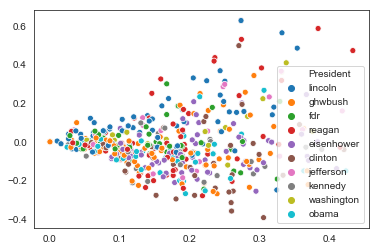

In [24]:
sns.scatterplot(X_train_lsa[:,0], X_train_lsa[:,1], hue = y_train);

In [25]:
pres = set(y_train)
colors = range(10)
pairs = {p: c for p, c in zip(pres, colors)}

In [26]:
# Creating a temp data frame combining lsa features with target.
temp_df = pd.DataFrame(X_train_lsa)
temp_df['target'] = y_train.values

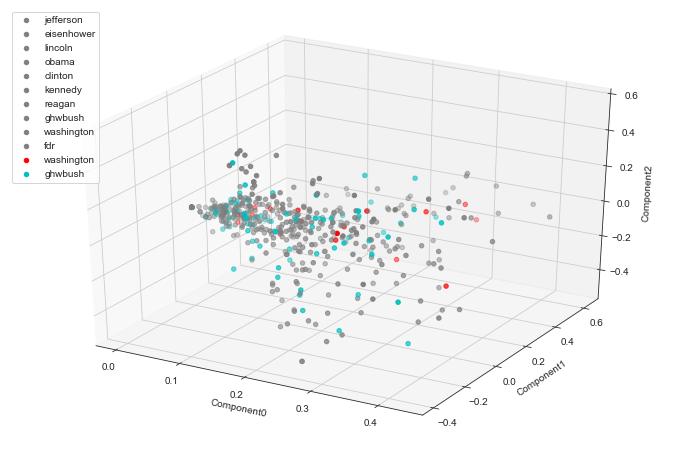

In [27]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
#ax = fig.gca(projection='3d')
#xs = X_train_lsa[:,0]
#ys = X_train_lsa[:,1]
#zs = X_train_lsa[:,2]
#p1mask = y_train == 'washington'
#scatter = ax.scatter(xs.iloc[p1mask], ys.iloc[p1mask], zs.iloc[p1mask],
#                     edgecolors='w', c = 'red')
#scatter = ax.scatter(xs, ys, zs, edgecolors='w', c = y_train.map(pairs))
#legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", 
#                    title="Classes") 
#ax.add_artist(legend1)

#ax.legend(*scatter.legend_elements())
for p, c in pairs.items():
    data = temp_df[(temp_df.target == p) & (p not in ['washington', 'ghwbush'])]
    xs = data.loc[:, 0]
    ys = data.loc[:, 1]
    zs = data.loc[:, 2]
    ax.scatter(xs, ys, zs, c='gray', label=p)
#    ax.scatter(xs, ys, zs, cmap='hot', label=p)
#    print(f'color:{c} label:{p}')

wash = temp_df[temp_df.target == 'washington']
xs = wash.loc[:, 0]
ys = wash.loc[:, 1]
zs = wash.loc[:, 2]
ax.scatter(xs, ys, zs, c='r', label='washington')

bush = temp_df[temp_df.target == 'ghwbush']
xs = bush.loc[:, 0]
ys = bush.loc[:, 1]
zs = bush.loc[:, 2]
ax.scatter(xs, ys, zs, c='c', label='ghwbush')

ax.set_xlabel('Component0')
ax.set_ylabel('Component1')
ax.set_zlabel('Component2')
ax.legend(loc=2)
#ax.legend(labels=(pairs.keys()));

In [28]:
# Instantiate MinMaxScaler.
scaler = MinMaxScaler()

In [29]:
# Create train/eval/holdout groups for LSA.
X_train_lsa_scaled = pd.DataFrame(scaler.fit_transform(X_train_lsa))
X_eval_lsa_scaled = pd.DataFrame(scaler.transform(X_eval_lsa))
X_holdout_lsa_scaled = pd.DataFrame(scaler.transform(X_holdout_lsa))

# Clustering Models

In [30]:
# Clustering models
models = []
names = []
plot_nums = []
silhouettes = []
clust = []

for clusters in range(2, 11):
    models.append(
        (0, 'KMeans', KMeans(n_clusters=clusters,
                             init='k-means++', random_state=15)))
    models.append(
        (1, 'MiniBatch', MiniBatchKMeans(init='random',
                                         n_clusters=clusters,
                                         batch_size=500)))
# Check for numbers.**
for _, name, model in models:
    names.append(name)
    model.fit(X_train_tfidf)
    labels = model.labels_
    print(model)
    if len(set(labels)) > 1:
        ypred = model.fit_predict(X_train_tfidf)
        silhouette = metrics.silhouette_score(
            X_train_tfidf, labels, metric='euclidean')
        silhouettes.append(silhouette)
        if silhouette > 0:
            print('clusters: {}\t silhouette: {}\n'.format(
                model.n_clusters, silhouette))
            print(name, '\n', pd.crosstab(ypred, labels), '\n')

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
clusters: 2	 silhouette: 0.024038081526201075

KMeans 
 col_0    0   1
row_0         
0      487   0
1        0  39 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
clusters: 2	 silhouette: 0.025189806162362816

MiniBatch 
 col_0    0   1
row_0         
0       78   1
1      436  11 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
clusters: 3	 silhouette: 0.025777622722872567

KMeans 
 col_0    0   1   2
row_0             
0      421   0   0
1        0  34   0
2        0   0  71 

MiniB

clusters: 10	 silhouette: 0.0387890509783065

KMeans 
 col_0    0   1   2   3   4   5   6   7   8   9
row_0                                         
0      251   0   0   0   0   0   0   0   0   0
1        0  45   0   0   0   0   0   0   0   0
2        0   0  24   0   0   0   0   0   0   0
3        0   0   0  29   0   0   0   0   0   0
4        0   0   0   0  21   0   0   0   0   0
5        0   0   0   0   0  61   0   0   0   0
6        0   0   0   0   0   0  27   0   0   0
7        0   0   0   0   0   0   0  30   0   0
8        0   0   0   0   0   0   0   0  18   0
9        0   0   0   0   0   0   0   0   0  20 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
clusters: 10	 silhouette: 0.029732570146056125

MiniBatch 
 col_0   0    1  2   3   4   5  6  7  8  9
row_0                                    
0

## Tfidf

In [31]:
# Re-run KMeans and extract cluster information.
model_tfidf = KMeans(n_clusters=10, random_state=15).fit(X_train_tfidf)

# Extract cluster assignments for each data point.
labels = model_tfidf.labels_

In [32]:
# Create cluster assignment for eval, holdout groups.
X_eval_tfidf_labels = model_tfidf.predict(X_eval_tfidf)
X_holdout_tfidf_labels = model_tfidf.predict(X_holdout_tfidf)

# Create a column for cluster labels.
X_eval_tfidf['clusters'] = X_eval_tfidf_labels
X_holdout_tfidf['clusters'] = X_holdout_tfidf_labels

X_train_tfidf['clusters'] = labels

In [33]:
# Aggregate by cluster.
X_train_tfidf_clusters = X_train_tfidf.groupby(
    ['clusters'], as_index=False).mean()
X_train_tfidf_clusters

,clusters,act,action,administration,america,american,american people,americans,ask,authority,...,way,willing,wish,woman,word,work,world,write,year,young
0,0,0.015,0.005,0.003,0.019,0.002,0.000,0.011,0.010,0.011,...,0.003,0.000,0.004,0.006,0.001,0.000,0.001,0.006,0.003,0.007
1,1,0.000,0.000,0.000,0.006,0.007,0.000,0.014,0.012,0.000,...,0.016,0.012,0.007,0.008,0.008,0.005,0.024,0.000,0.000,0.016
2,2,0.000,0.000,0.000,0.017,0.000,0.000,0.012,0.000,0.000,...,0.030,0.030,0.000,0.000,0.010,0.000,0.017,0.000,0.015,0.000
3,3,0.000,0.000,0.000,0.016,0.021,0.000,0.019,0.000,0.000,...,0.037,0.018,0.000,0.000,0.000,0.000,0.015,0.000,0.000,0.000
4,4,0.000,0.009,0.018,0.000,0.023,0.000,0.043,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000
5,5,0.005,0.009,0.008,0.029,0.021,0.023,0.000,0.006,0.016,...,0.008,0.000,0.008,0.015,0.005,0.000,0.195,0.000,0.006,0.000
6,6,0.011,0.036,0.000,0.015,0.013,0.014,0.027,0.016,0.000,...,0.000,0.000,0.000,0.000,0.160,0.000,0.025,0.053,0.030,0.012
7,7,0.000,0.018,0.025,0.000,0.008,0.009,0.000,0.039,0.004,...,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.044,0.000
8,8,0.027,0.000,0.000,0.021,0.000,0.000,0.036,0.017,0.000,...,0.000,0.019,0.000,0.000,0.015,0.505,0.000,0.018,0.000,0.000
9,9,0.019,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.019,0.000,0.000,0.000,0.000,0.000


In [34]:
num_clusters = model_tfidf.n_clusters
for i in range(num_clusters):
    data_train = X_train_tfidf[X_train_tfidf['clusters'] == i]
    data_eval = X_eval_tfidf[X_eval_tfidf['clusters'] == i]
    print(f'Cluster {i}:')
    if i < 1:
        train = data_train.mean().sort_values(ascending=False)[:10].copy()
        print(train)
        print()
        evl = data_eval.mean().sort_values(ascending=False)[:10].copy()
        print(evl)
        print()
        train_set, eval_set = {*train.index}, {*evl.index}
        overlap = train_set.intersection(eval_set)
        print((f'There are {len(overlap)} words that are in the top ten of \
        both training and testing.'))
        if len(overlap) > 0:
            print(f'These words are: {overlap}.')
        print()
    elif i >= 1:
        train = data_train.mean().sort_values(ascending=False)[1:11].copy()
        print(train)
        print()
        evl = data_eval.mean().sort_values(ascending=False)[1:11].copy()
        print(evl)
        print()
        train_set, eval_set = {*train.index}, {*evl.index}
        overlap = train_set.intersection(eval_set)
        print(f'There are {len(overlap)} words that are in the top ten of \
        both training and testing.')
        if len(overlap) > 0:
            print(f'These words are: {overlap}.')
        print()

Cluster 0:
day            0.028
freedom        0.022
god            0.021
right          0.020
union          0.019
constitution   0.019
america        0.019
make           0.019
man            0.018
old            0.017
dtype: float64

principle    0.031
law          0.029
believe      0.027
faith        0.026
states       0.024
way          0.023
new          0.023
generation   0.021
union        0.021
case         0.021
dtype: float64

There are 1 words that are in the top ten of         both training and testing.
These words are: {'union'}.

Cluster 1:
time         0.262
nation       0.229
government   0.053
change       0.045
great        0.038
live         0.031
make         0.030
require      0.029
god          0.028
believe      0.028
dtype: float64

nation    0.289
time      0.209
freedom   0.134
great     0.101
new       0.095
right     0.094
think     0.075
speak     0.073
power     0.062
future    0.060
dtype: float64

There are 3 words that are in the top ten of         bo

## LSA

In [35]:
# Re-run KMeans and extract cluster information.
model_lsa = KMeans(n_clusters=10, random_state=42).fit(X_train_lsa_scaled)

# Extract cluster assignments for each data point.
labels = model_lsa.labels_

In [36]:
# Create cluster assignment for eval, holdout groups.
X_eval_lsa_labels = model_lsa.predict(X_eval_lsa_scaled)
X_holdout_lsa_labels = model_lsa.predict(X_holdout_lsa_scaled)

# Create a column for cluster labels.
X_eval_lsa_scaled['clusters'] = X_eval_lsa_labels
X_holdout_lsa_scaled['clusters'] = X_holdout_lsa_labels

X_train_lsa_scaled['clusters'] = labels

In [37]:
# Aggregate by cluster.
X_train_lsa_clusters = X_train_lsa_scaled.groupby(
    ['clusters'], as_index=False).mean()
X_train_lsa_clusters

,clusters,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0.265,0.421,0.470,0.368,0.478,0.467,0.460,0.464,0.396,...,0.579,0.443,0.394,0.336,0.587,0.454,0.503,0.679,0.311,0.426
1,1,0.582,0.556,0.351,0.437,0.735,0.359,0.590,0.464,0.383,...,0.477,0.431,0.427,0.356,0.481,0.360,0.463,0.529,0.340,0.499
2,2,0.246,0.365,0.508,0.353,0.448,0.420,0.444,0.481,0.479,...,0.483,0.417,0.404,0.376,0.472,0.370,0.475,0.539,0.355,0.505
3,3,0.373,0.406,0.493,0.298,0.464,0.546,0.448,0.475,0.423,...,0.554,0.428,0.384,0.324,0.499,0.356,0.488,0.511,0.349,0.506
4,4,0.409,0.257,0.563,0.370,0.531,0.295,0.352,0.488,0.544,...,0.484,0.426,0.392,0.390,0.489,0.372,0.450,0.523,0.359,0.493
5,5,0.337,0.428,0.511,0.355,0.489,0.330,0.515,0.571,0.289,...,0.522,0.444,0.376,0.364,0.497,0.359,0.430,0.523,0.315,0.512
6,6,0.157,0.448,0.484,0.367,0.491,0.407,0.455,0.502,0.542,...,0.528,0.401,0.408,0.362,0.476,0.388,0.539,0.567,0.360,0.503
7,7,0.645,0.416,0.472,0.383,0.450,0.359,0.467,0.550,0.343,...,0.506,0.402,0.397,0.374,0.495,0.368,0.479,0.532,0.344,0.501
8,8,0.541,0.144,0.204,0.318,0.381,0.445,0.257,0.428,0.227,...,0.498,0.403,0.434,0.372,0.496,0.391,0.506,0.560,0.332,0.503
9,9,0.516,0.467,0.439,0.477,0.511,0.360,0.337,0.463,0.366,...,0.259,0.638,0.457,0.303,0.534,0.346,0.691,0.572,0.368,0.475


In [38]:
num_clusters = model_lsa.n_clusters
for i in range(num_clusters):
    data_train = X_train_lsa_scaled[X_train_lsa_scaled['clusters'] == i]
    data_eval = X_eval_lsa_scaled[X_eval_lsa_scaled['clusters'] == i]
    print(f'Cluster {i}:')
    if i < 1:
        train = data_train.mean().sort_values(ascending=False)[:10].copy()
        print(train)
        print()
        evl = data_eval.mean().sort_values(ascending=False)[:10].copy()
        print(evl)
        print()
        train_set, eval_set = {*train.index}, {*evl.index}
        overlap = train_set.intersection(eval_set)
        print((f'There are {len(overlap)} features that are in the top ten of both training and testing.'))
        if len(overlap) > 0:
            print(f'These features are: {overlap}.')
        print()
    elif i >= 1:
        train = data_train.mean().sort_values(ascending=False)[1:11].copy()
        print(train)
        print()
        evl = data_eval.mean().sort_values(ascending=False)[1:11].copy()
        print(evl)
        print()
        train_set, eval_set = {*train.index}, {*evl.index}
        overlap = train_set.intersection(eval_set)
        print(f'There are {len(overlap)} features that are in the top ten of both training and testing.')
        if len(overlap) > 0:
            print(f'These features are: {overlap}.')
        print()

Cluster 0:
47   0.739
44   0.726
67   0.689
97   0.679
71   0.663
55   0.645
53   0.641
74   0.629
77   0.609
33   0.593
dtype: float64

47   0.839
71   0.836
60   0.766
3    0.725
97   0.716
44   0.701
8    0.690
77   0.674
76   0.666
67   0.659
dtype: float64

There are 6 features that are in the top ten of both training and testing.
These features are: {97, 67, 71, 44, 77, 47}.

Cluster 1:
25   0.785
27   0.742
4    0.735
32   0.669
38   0.631
21   0.627
36   0.605
6    0.590
71   0.583
0    0.582
dtype: float64

25   0.822
27   0.776
71   0.701
11   0.644
21   0.643
38   0.639
32   0.638
4    0.636
77   0.620
9    0.602
dtype: float64

There are 7 features that are in the top ten of both training and testing.
These features are: {32, 4, 38, 71, 21, 25, 27}.

Cluster 2:
97   0.539
55   0.535
49   0.524
44   0.522
58   0.519
41   0.516
12   0.515
9    0.514
85   0.509
2    0.508
dtype: float64

55   0.546
97   0.531
44   0.523
85   0.514
67   0.514
49   0.513
72   0.512
99   0.509
12

## Latent Dirichlet Allocation (LDA)

### Set up text for LDA

In [39]:
# For TF DTM.
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=15)
lda_tf.fit(dtm_tf)

# For TFIDF DTM.
lda_tfidf = LatentDirichletAllocation(n_topics=10, random_state=15)
lda_tfidf.fit(dtm_tfidf)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=15, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [40]:
# For TF DTM.
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=15)
lda_tf.fit(dtm_tf)

# For TFIDF DTM.
lda_tfidf = LatentDirichletAllocation(n_topics=10, random_state=15)
lda_tfidf.fit(dtm_tfidf)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=15, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

## Visualizing the Models With pyLDAvis

In [41]:
# Prepare pyLDAvis model.
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
2     -0.125 -0.032       1        1 15.032
6      0.233  0.096       2        1 13.044
1     -0.012 -0.088       3        1 11.108
3      0.080 -0.031       4        1 10.376
8      0.048  0.144       5        1 10.048
9      0.087 -0.252       6        1  8.932
0     -0.053  0.054       7        1  8.900
7     -0.029  0.059       8        1  8.757
5     -0.106  0.029       9        1  7.274
4     -0.122  0.022      10        1  6.529, topic_info=    Category   Freq          Term  Total  loglift  logprob
206  Default 31.000          time 31.000   30.000   30.000
108  Default 26.000           let 26.000   29.000   29.000
42   Default 21.000           day 21.000   28.000   28.000
227  Default 40.000         world 40.000   27.000   27.000
177  Default 23.000         right 23.000   26.000   26.000
72   Default 29.000          free 29.000   25.000   25.000
78   Default 14.000           god 14.000   24.000   24.000
74   Default 20.000       freedom 20.000   23.000   23.000
68   Default 18.000        fellow 18.000   22.000   22.000
121  Default 32.000           man 32.000   21.000   21.000
80   Default 41.000    government 41.000   20.000   20.000
79   Default 30.000          good 30.000   19.000   19.000
24   Default 17.000       citizen 17.000   18.000   18.000
135  Default 19.000           new 19.000   17.000   17.000
187  Default 26.000         shall 26.000   16.000   16.000
157  Default 13.000     president 13.000   15.000   15.000
155  Default  9.000       present  9.000   14.000   14.000
213  Default 11.000         union 11.000   13.000   13.000
131  Default 36.000        nation 36.000   12.000   12.000
3    Default 19.000       america 19.000   11.000   11.000
120  Default 34.000          make 34.000   10.000   10.000
11   Default 10.000         begin 10.000    9.000    9.000
163  Default 11.000        public 11.000    8.000    8.000
205  Default  7.000         think  7.000    7.000    7.000
147  Default 53.000        people 53.000    6.000    6.000
214  Default 11.000        united 11.000    5.000    5.000
153  Default 22.000         power 22.000    4.000    4.000
145  Default 17.000         peace 17.000    3.000    3.000
111  Default 21.000          life 21.000    2.000    2.000
86   Default  8.000         heart  8.000    1.000    1.000
..       ...    ...           ...    ...      ...      ...
114  Topic10  1.953        little  6.367    1.547   -4.343
129  Topic10  2.667        moment  9.113    1.500   -4.031
229  Topic10  2.883          year 10.062    1.479   -3.954
57   Topic10  1.833     executive  8.239    1.226   -4.406
4    Topic10  1.953      american  9.111    1.189   -4.343
113  Topic10  1.226          like  6.389    1.078   -4.808
88   Topic10  1.023          hero  5.431    1.060   -4.990
143  Topic10  1.023          pass  5.451    1.056   -4.990
139  Topic10  1.023       opinion  5.454    1.055   -4.990
174  Topic10  1.023       restore  5.455    1.055   -4.990
191  Topic10  1.023        spirit  5.455    1.055   -4.989
43   Topic10  1.023      decision  5.462    1.054   -4.990
128  Topic10  1.023          mind  5.463    1.054   -4.990
62   Topic10  1.023       factory  5.520    1.043   -4.990
61   Topic10  1.023          fact  6.359    0.902   -4.990
167  Topic10  1.023        reject  6.360    0.901   -4.990
18   Topic10  1.023       century  6.361    0.901   -4.990
97   Topic10  1.023    individual  6.364    0.901   -4.989
81   Topic10  3.813         great 27.145    0.766   -3.674
3    Topic10  2.654       america 19.739    0.723   -4.036
121  Topic10  3.654           man 32.832    0.533   -3.716
79   Topic10  3.281          good 30.024    0.515   -3.824
111  Topic10  2.397          life 21.922    0.516   -4.138
147  Topic10  2.883        people 53.760   -0.197   -3.954
80   Topic10  2.345    government 41.193   -0.137   -4.160
46   Topic10  1.145    difference  9.075    0.658   -4.877
11   To

In [42]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
2      0.175  0.002       1        1 16.872
6      0.039  0.127       2        1 12.616
0      0.066 -0.103       3        1 10.604
7     -0.051  0.032       4        1  9.689
5      0.084 -0.033       5        1  9.501
1      0.022  0.108       6        1  9.305
3     -0.045 -0.099       7        1  8.909
8     -0.151  0.086       8        1  7.888
4     -0.091 -0.146       9        1  7.784
9     -0.048  0.026      10        1  6.831, topic_info=    Category   Freq         Term  Total  loglift  logprob
42   Default  9.000          day  9.000   30.000   30.000
135  Default  8.000          new  8.000   29.000   29.000
108  Default 10.000          let 10.000   28.000   28.000
74   Default  8.000      freedom  8.000   27.000   27.000
54   Default  4.000        enemy  4.000   26.000   26.000
226  Default  8.000         work  8.000   25.000   25.000
81   Default  9.000        great  9.000   24.000   24.000
227  Default 12.000        world 12.000   23.000   23.000
68   Default  6.000       fellow  6.000   22.000   22.000
24   Default  6.000      citizen  6.000   21.000   21.000
72   Default  8.000         free  8.000   20.000   20.000
111  Default 10.000         life 10.000   19.000   19.000
3    Default  8.000      america  8.000   18.000   18.000
213  Default  4.000        union  4.000   17.000   17.000
78   Default  7.000          god  7.000   16.000   16.000
203  Default  4.000        thank  4.000   15.000   15.000
212  Default  4.000   understand  4.000   14.000   14.000
0    Default  5.000          act  5.000   13.000   13.000
60   Default  5.000         face  5.000   12.000   12.000
165  Default  4.000     question  4.000   11.000   11.000
79   Default 10.000         good 10.000   10.000   10.000
80   Default 12.000   government 12.000    9.000    9.000
131  Default 11.000       nation 11.000    8.000    8.000
11   Default  5.000        begin  5.000    7.000    7.000
121  Default  9.000          man  9.000    6.000    6.000
8    Default  4.000    authority  4.000    5.000    5.000
106  Default  3.000   leadership  3.000    4.000    4.000
6    Default  5.000    americans  5.000    3.000    3.000
12   Default  4.000      believe  4.000    2.000    2.000
63   Default  6.000        faith  6.000    1.000    1.000
..       ...    ...          ...    ...      ...      ...
114  Topic10  1.133       little  3.301    1.614   -4.071
75   Topic10  1.686       friend  5.205    1.556   -3.672
70   Topic10  1.228        force  4.810    1.318   -3.990
144  Topic10  0.648   patriotism  2.760    1.235   -4.628
22   Topic10  0.658       choose  3.150    1.118   -4.613
0    Topic10  1.052          act  5.167    1.092   -4.145
175  Topic10  0.556       return  2.738    1.089   -4.782
57   Topic10  0.643    executive  3.318    1.042   -4.637
29   Topic10  0.552      concern  2.938    1.011   -4.790
17   Topic10  0.703         case  3.775    1.003   -4.547
205  Topic10  0.703        think  3.997    0.946   -4.547
62   Topic10  0.592      factory  3.399    0.936   -4.719
186  Topic10  0.681      service  4.017    0.909   -4.579
140  Topic10  0.406  opportunity  2.396    0.908   -5.096
58   Topic10  0.406     exercise  2.425    0.897   -5.096
78   Topic10  1.264          god  7.580    0.893   -3.961
134  Topic10  1.149         need  6.967    0.881   -4.056
40   Topic10  0.493         dare  3.062    0.858   -4.901
168  Topic10  0.544       remain  3.452    0.836   -4.804
98   Topic10  0.406   instrument  2.587    0.832   -5.096
182  Topic10  0.457     security  2.916    0.831   -4.977
196  Topic10  0.470       strive  2.999    0.830   -4.950
63   Topic10  0.923        faith  6.242    0.772   -4.275
187  Topic10  1.181        shall  8.384    0.724   -4.029
44   Topic10  0.531         deny  3.565    0.780   -4.827
226  Topic10  0.901         work  8.414    0.449   -4.300
101  Topic10  0.771         know  7.304    0.435   -4.455
177  To

In [43]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
2     -0.132 -0.075       1        1 15.032
6      0.149  0.268       2        1 13.044
1     -0.171  0.147       3        1 11.108
3      0.100 -0.007       4        1 10.376
8      0.243 -0.190       5        1 10.048
9      0.294  0.083       6        1  8.932
0     -0.054  0.237       7        1  8.900
7      0.029 -0.254       8        1  8.757
5     -0.279  0.026       9        1  7.274
4     -0.178 -0.234      10        1  6.529, topic_info=    Category   Freq          Term  Total  loglift  logprob
206  Default 31.000          time 31.000   30.000   30.000
108  Default 26.000           let 26.000   29.000   29.000
42   Default 21.000           day 21.000   28.000   28.000
227  Default 40.000         world 40.000   27.000   27.000
177  Default 23.000         right 23.000   26.000   26.000
72   Default 29.000          free 29.000   25.000   25.000
78   Default 14.000           god 14.000   24.000   24.000
74   Default 20.000       freedom 20.000   23.000   23.000
68   Default 18.000        fellow 18.000   22.000   22.000
121  Default 32.000           man 32.000   21.000   21.000
80   Default 41.000    government 41.000   20.000   20.000
79   Default 30.000          good 30.000   19.000   19.000
24   Default 17.000       citizen 17.000   18.000   18.000
135  Default 19.000           new 19.000   17.000   17.000
187  Default 26.000         shall 26.000   16.000   16.000
157  Default 13.000     president 13.000   15.000   15.000
155  Default  9.000       present  9.000   14.000   14.000
213  Default 11.000         union 11.000   13.000   13.000
131  Default 36.000        nation 36.000   12.000   12.000
3    Default 19.000       america 19.000   11.000   11.000
120  Default 34.000          make 34.000   10.000   10.000
11   Default 10.000         begin 10.000    9.000    9.000
163  Default 11.000        public 11.000    8.000    8.000
205  Default  7.000         think  7.000    7.000    7.000
147  Default 53.000        people 53.000    6.000    6.000
214  Default 11.000        united 11.000    5.000    5.000
153  Default 22.000         power 22.000    4.000    4.000
145  Default 17.000         peace 17.000    3.000    3.000
111  Default 21.000          life 21.000    2.000    2.000
86   Default  8.000         heart  8.000    1.000    1.000
..       ...    ...           ...    ...      ...      ...
114  Topic10  1.953        little  6.367    1.547   -4.343
129  Topic10  2.667        moment  9.113    1.500   -4.031
229  Topic10  2.883          year 10.062    1.479   -3.954
57   Topic10  1.833     executive  8.239    1.226   -4.406
4    Topic10  1.953      american  9.111    1.189   -4.343
113  Topic10  1.226          like  6.389    1.078   -4.808
88   Topic10  1.023          hero  5.431    1.060   -4.990
143  Topic10  1.023          pass  5.451    1.056   -4.990
139  Topic10  1.023       opinion  5.454    1.055   -4.990
174  Topic10  1.023       restore  5.455    1.055   -4.990
191  Topic10  1.023        spirit  5.455    1.055   -4.989
43   Topic10  1.023      decision  5.462    1.054   -4.990
128  Topic10  1.023          mind  5.463    1.054   -4.990
62   Topic10  1.023       factory  5.520    1.043   -4.990
61   Topic10  1.023          fact  6.359    0.902   -4.990
167  Topic10  1.023        reject  6.360    0.901   -4.990
18   Topic10  1.023       century  6.361    0.901   -4.990
97   Topic10  1.023    individual  6.364    0.901   -4.989
81   Topic10  3.813         great 27.145    0.766   -3.674
3    Topic10  2.654       america 19.739    0.723   -4.036
121  Topic10  3.654           man 32.832    0.533   -3.716
79   Topic10  3.281          good 30.024    0.515   -3.824
111  Topic10  2.397          life 21.922    0.516   -4.138
147  Topic10  2.883        people 53.760   -0.197   -3.954
80   Topic10  2.345    government 41.193   -0.137   -4.160
46   Topic10  1.145    difference  9.075    0.658   -4.877
11   To

In [44]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            x       y  topics  cluster   Freq
topic                                        
2      26.320  32.835       1        1 15.032
6      19.842  95.065       2        1 13.044
1      76.881  69.501       3        1 11.108
3     -44.247  75.736       4        1 10.376
8     111.624  13.431       5        1 10.048
9      72.385 143.172       6        1  8.932
0      -7.835 152.116       7        1  8.900
7      49.777 -27.540       8        1  8.757
5     134.982  95.303       9        1  7.274
4     -30.235   1.955      10        1  6.529, topic_info=    Category   Freq          Term  Total  loglift  logprob
206  Default 31.000          time 31.000   30.000   30.000
108  Default 26.000           let 26.000   29.000   29.000
42   Default 21.000           day 21.000   28.000   28.000
227  Default 40.000         world 40.000   27.000   27.000
177  Default 23.000         right 23.000   26.000   26.000
72   Default 29.000          free 29.000   25.000   25.000
78   Default 14.000           god 14.000   24.000   24.000
74   Default 20.000       freedom 20.000   23.000   23.000
68   Default 18.000        fellow 18.000   22.000   22.000
121  Default 32.000           man 32.000   21.000   21.000
80   Default 41.000    government 41.000   20.000   20.000
79   Default 30.000          good 30.000   19.000   19.000
24   Default 17.000       citizen 17.000   18.000   18.000
135  Default 19.000           new 19.000   17.000   17.000
187  Default 26.000         shall 26.000   16.000   16.000
157  Default 13.000     president 13.000   15.000   15.000
155  Default  9.000       present  9.000   14.000   14.000
213  Default 11.000         union 11.000   13.000   13.000
131  Default 36.000        nation 36.000   12.000   12.000
3    Default 19.000       america 19.000   11.000   11.000
120  Default 34.000          make 34.000   10.000   10.000
11   Default 10.000         begin 10.000    9.000    9.000
163  Default 11.000        public 11.000    8.000    8.000
205  Default  7.000         think  7.000    7.000    7.000
147  Default 53.000        people 53.000    6.000    6.000
214  Default 11.000        united 11.000    5.000    5.000
153  Default 22.000         power 22.000    4.000    4.000
145  Default 17.000         peace 17.000    3.000    3.000
111  Default 21.000          life 21.000    2.000    2.000
86   Default  8.000         heart  8.000    1.000    1.000
..       ...    ...           ...    ...      ...      ...
114  Topic10  1.953        little  6.367    1.547   -4.343
129  Topic10  2.667        moment  9.113    1.500   -4.031
229  Topic10  2.883          year 10.062    1.479   -3.954
57   Topic10  1.833     executive  8.239    1.226   -4.406
4    Topic10  1.953      american  9.111    1.189   -4.343
113  Topic10  1.226          like  6.389    1.078   -4.808
88   Topic10  1.023          hero  5.431    1.060   -4.990
143  Topic10  1.023          pass  5.451    1.056   -4.990
139  Topic10  1.023       opinion  5.454    1.055   -4.990
174  Topic10  1.023       restore  5.455    1.055   -4.990
191  Topic10  1.023        spirit  5.455    1.055   -4.989
43   Topic10  1.023      decision  5.462    1.054   -4.990
128  Topic10  1.023          mind  5.463    1.054   -4.990
62   Topic10  1.023       factory  5.520    1.043   -4.990
61   Topic10  1.023          fact  6.359    0.902   -4.990
167  Topic10  1.023        reject  6.360    0.901   -4.990
18   Topic10  1.023       century  6.361    0.901   -4.990
97   Topic10  1.023    individual  6.364    0.901   -4.989
81   Topic10  3.813         great 27.145    0.766   -3.674
3    Topic10  2.654       america 19.739    0.723   -4.036
121  Topic10  3.654           man 32.832    0.533   -3.716
79   Topic10  3.281          good 30.024    0.515   -3.824
111  Topic10  2.397          life 21.922    0.516   -4.138
147  Topic10  2.883        people 53.760   -0.197   -3.954
80   Topic10  2.345    government 41.193   -0.137   -4.160
46   Topic10  1.145    difference  9.075  

In [45]:
# # Removing numerals.
# sent_df['sentence_tokens'] = sent_df.sentence.map(
#     lambda x: re.sub(r'\d+', '', x))
# # Lower case.
# sent_df['sentence_tokens'] = sent_df.sentence_tokens.map(lambda x: x.lower())
# print(sent_df['sentence_tokens'][0][:500])

In [46]:
# # Tokenize.
# sent_df['sentence_tokens'] = sent_df.sentence_tokens.map(
#     lambda x: RegexpTokenizer(r'\w+').tokenize(x))
# print(sent_df['sentence_tokens'][0][:25])

In [47]:
# # Stemming.
# snowball = SnowballStemmer("english")
# sent_df['sentence_tokens'] = sent_df.sentence_tokens.map(
#     lambda x: [snowball.stem(token) for token in x])
# print(sent_df['sentence_tokens'][0][:25])

In [48]:
# # Stop words.
# stop_en = stopwords.words('english')
# sent_df['sentence_tokens'] = sent_df.sentence_tokens.map(
#     lambda x: [t for t in x if t not in stop_en])
# print(sent_df['sentence_tokens'][0][:25])

In [49]:
# # Final cleaning.
# sent_df['sentence_tokens'] = sent_df.sentence_tokens.map(
#     lambda x: [t for t in x if len(t) > 1])
# print(sent_df['sentence_tokens'][0][:25])

### Run LDA

In [50]:
# texts = sent_df['sentence_tokens']
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]
# lda = LdaModel(corpus,
#                id2word=dictionary,
#                num_topics=10,
#                passes=5,
#                minimum_probability=0,
#                random_state=15)

In [51]:
# # Print topics
# lda.print_topics()

In [52]:
# # Refactoring results of LDA into numpy matrix.
# hm = np.array([[y for (x,y) in lda[corpus[i]]] for i in range(len(corpus))])

In [53]:
# # Reduce dimensionality using t-SNE.
# tsne = TSNE(random_state=15, perplexity=30, early_exaggeration=120)
# embedding = tsne.fit_transform(hm)
# embedding = pd.DataFrame(embedding, columns=['x','y'])
# embedding['hue'] = hm.argmax(axis=1)

In [54]:
# # Scatter plot using Bokeh.
# source = ColumnDataSource(
#     data=dict(x=embedding.x,
#               y=embedding.y,
#               colors=[all_palettes['Set1'][9] for i in embedding.hue],
#               sentence=sent_df.sentence,
#               President=sent_df.President,
#               alpha=[0.9] * embedding.shape[0],
#               size=[7] * embedding.shape[0]
#               )
# )
# hover_tsne = HoverTool(names=["sent_df"], tooltips="""
#     <div style="margin: 10">
#         <div style="margin: 0 auto; width:300px;">
#             <span style="font-size: 12px; font-weight: bold;">Title:</span>
#             <span style="font-size: 12px">@title</span>
#             <span style="font-size: 12px; font-weight: bold;">Year:</span>
#             <span style="font-size: 12px">@year</span>
#         </div>
#     </div>
#     """)
# tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
# plot_tsne = figure(plot_width=700, plot_height=700,
#                    tools=tools_tsne, title='Inaugural Addresses')
# plot_tsne.circle('x', 'y', size='size', fill_color='colors',alpha='alpha',
#                  line_alpha=0, line_width=0.01, source=source, name="sent_df")


# callback = CustomJS(args=dict(source=source), code=
#     """var data = source.data;
#     var f = cb_obj.value
#     x = data['x']
#     y = data['y']
#     colors = data['colors']
#     alpha = data['alpha']
#     title = data['title']
#     President = data['President']
#     size = data['size']
#     for (i = 0; i < x.length; i++) {
#         if (year[i] <= f) {
#             alpha[i] = 0.9
#             size[i] = 7
#         } else {
#             alpha[i] = 0.05
#             size[i] = 4
#         }
#     }
#     source.change.emit();
#     """)
# slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")
# #slider = Slider(
# #    start=sent_df.President.min(), end=sent_df.sentence.max(),values=
# #    ['Washington', 'Jefferson', 'Lincoln', 'FDR', 'Eisenhower', 'Kennedy', 'Reagan', 'GHWBush', 'Clinton', 'Obama'], step=1, title="Inaugural Speeches")
# slider.js_on_change('value', callback)

# layout = column(plot_tsne)
# show(layout)

# Prepare for Predictive Modeling

In [55]:
'''Create baseline score to beat. GHWBush had the most sentences, so guessing 
him for all sentences would give this percentage.
'''

print('Baseline score to beat:', sum(
    (sent_df.President == 'ghwbush') / len(sent_df.President)))

Baseline score to beat: 0.15491452991452967


In [56]:
# Pipeline helpers.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

In [57]:
# Instantiate the models.
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=15)
tree = DecisionTreeClassifier(random_state=15)
forest = RandomForestClassifier(max_depth=10, random_state=15)
boost = GradientBoostingClassifier(random_state=15)
nb = BernoulliNB()

In [58]:
# Set up _kwargs files for convenience.
tfidf_kwargs = {'X_train': X_train_tfidf,'y_train': y_train,
                'X_eval': X_eval_tfidf,'y_eval': y_eval}
                #'X_holdout': X_holdout_tfidf, 'y_holdout': y_holdout}

lsa_kwargs = {'X_train': X_train_lsa_scaled, 'y_train': y_train,
              'X_eval': X_eval_lsa_scaled, 'y_eval': y_eval}
              #'X_holdout': X_holdout_tfidf_scaled, 'y_holdout': y_holdout}

In [59]:
# Tune parameter grids.
log_reg_params = {'model__C': [1, 10, 100, 1000]}
tree_params = {'model__criterion': ['gini']}
forest_params = {'model__n_estimators': [100, 200, 300,400],
                 'model__max_depth': [None, 5, 10]}
boost_params = {'model__n_estimators': [100]}
nb_params = {'model__alpha': [1]}

In [60]:
# Function to fit and predict all working kernals.


def fit_and_predict(model, params: Dict,
                    X_train: pd.DataFrame,
                    y_train: pd.DataFrame,
                    X_eval: pd.DataFrame,
                    y_eval: pd.DataFrame) -> None:
    """
    Takes an instantiated sklearn model, training data (X_train, y_train), 
    and performs cross-validation and then prints the mean of the cross-
    validation accuracies.
    """
    assert len(X_train) == len(y_train)
    assert len(X_eval) == len(y_eval)
    # assert len(X_holdout) == len(y_holdout)
    pipe = Pipeline(steps=[('model', model)])
    clf = GridSearchCV(pipe, cv=skf, param_grid=params, n_jobs=2)
    clf.fit(X_train, y_train)
    print('The mean cross_val accuracy on train is',
          f'{clf.cv_results_["mean_test_score"]}.')
    print('The std of the cross_val accuracy is',
          f'{clf.cv_results_["std_test_score"]}.')
    y_pred = clf.predict(X_eval)
    print(classification_report(y_eval, y_pred))
    print(confusion_matrix(y_eval, y_pred))

## Logistic Regression

### Tfidf

In [61]:
fit_and_predict(log_reg, params=log_reg_params, **tfidf_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The mean cross_val accuracy on train is [0.3460076  0.34220532 0.31558935 0.28326996].
The std of the cross_val accuracy is [0.03517412 0.02098996 0.04191145 0.04905875].
              precision    recall  f1-score   support

     clinton       0.33      0.12      0.18        16
  eisenhower       0.33      0.42      0.37        19
         fdr       0.25      0.06      0.10        16
     ghwbush       0.15      0.44      0.22        25
   jefferson       1.00      0.10      0.18        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.58      0.62      0.60        29
       obama       0.00      0.00      0.00        25
      reagan       0.25      0.33      0.29        24
  washington       0.00      0.00      0.00         3

   micro avg       0.28      0.28      0.28       176
   macro avg       0.29      0.21      0.19       176
weighted avg       0.30      0.28      0.25       176

[[ 2  1  0  9  0  1  0  0  3  0]
 [ 0  8  0  7  0  0  1  2  1  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA (Latent Semantic Analysis)

In [62]:
fit_and_predict(log_reg, params=log_reg_params, **lsa_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The mean cross_val accuracy on train is [0.31368821 0.31939163 0.31558935 0.30228137].
The std of the cross_val accuracy is [0.03308349 0.0311812  0.04997338 0.04755442].
              precision    recall  f1-score   support

     clinton       0.25      0.25      0.25        16
  eisenhower       0.36      0.47      0.41        19
         fdr       0.47      0.44      0.45        16
     ghwbush       0.16      0.32      0.21        25
   jefferson       0.43      0.30      0.35        10
     kennedy       0.40      0.22      0.29         9
     lincoln       0.64      0.62      0.63        29
       obama       0.17      0.04      0.06        25
      reagan       0.35      0.29      0.32        24
  washington       0.67      0.67      0.67         3

   micro avg       0.35      0.35      0.35       176
   macro avg       0.39      0.36      0.36       176
weighted avg       0.36      0.35      0.34       176

[[ 4  1  1  8  0  1  0  0  1  0]
 [ 0  9  0  8  0  0  1  1  0  0]
 [ 0

## Decision Trees

### Tfidf

In [63]:
fit_and_predict(tree, params=tree_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.26996198].
The std of the cross_val accuracy is [0.05939566].
              precision    recall  f1-score   support

     clinton       0.08      0.06      0.07        16
  eisenhower       0.24      0.32      0.27        19
         fdr       0.00      0.00      0.00        16
     ghwbush       0.11      0.28      0.16        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.67      0.22      0.33         9
     lincoln       0.52      0.41      0.46        29
       obama       0.23      0.12      0.16        25
      reagan       0.23      0.21      0.22        24
  washington       0.00      0.00      0.00         3

   micro avg       0.20      0.20      0.20       176
   macro avg       0.21      0.16      0.17       176
weighted avg       0.23      0.20      0.20       176

[[ 1  1  0 10  0  0  0  1  3  0]
 [ 0  6  2  8  0  0  1  1  1  0]
 [ 1  2  0  8  1  0  1  0  3  0]
 [ 4  3  3  7  0  0  3  2  2  1]
 [ 0

### LSA

In [64]:
fit_and_predict(tree, params=tree_params, **lsa_kwargs)

The mean cross_val accuracy on train is [0.21292776].
The std of the cross_val accuracy is [0.04921557].
              precision    recall  f1-score   support

     clinton       0.00      0.00      0.00        16
  eisenhower       0.15      0.21      0.17        19
         fdr       0.29      0.25      0.27        16
     ghwbush       0.15      0.28      0.20        25
   jefferson       0.25      0.10      0.14        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.41      0.38      0.39        29
       obama       0.13      0.08      0.10        25
      reagan       0.09      0.08      0.09        24
  washington       0.00      0.00      0.00         3

   micro avg       0.18      0.18      0.18       176
   macro avg       0.15      0.14      0.14       176
weighted avg       0.18      0.18      0.17       176

[[ 0  1  1  7  0  2  1  1  2  1]
 [ 0  4  0  7  0  1  3  3  1  0]
 [ 0  3  4  2  0  0  2  1  3  1]
 [ 1  4  2  7  0  1  5  3  2  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Random Forest

### Tfidf

In [65]:
fit_and_predict(forest, params=forest_params, **tfidf_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The mean cross_val accuracy on train is [0.30418251 0.32129278 0.32319392 0.32319392 0.28707224 0.29277567
 0.29087452 0.28136882 0.2851711  0.29277567 0.30418251 0.30418251].
The std of the cross_val accuracy is [0.0294265  0.0316737  0.0353509  0.03592705 0.05275027 0.05193235
 0.04611536 0.0494077  0.05074101 0.05179239 0.04375188 0.04720934].
              precision    recall  f1-score   support

     clinton       0.27      0.25      0.26        16
  eisenhower       0.22      0.32      0.26        19
         fdr       0.18      0.12      0.15        16
     ghwbush       0.14      0.28      0.18        25
   jefferson       0.50      0.30      0.37        10
     kennedy       1.00      0.11      0.20         9
     lincoln       0.56      0.52      0.54        29
       obama       0.07      0.04      0.05        25
      reagan       0.30      0.29      0.30        24
  washington       0.00      0.00      0.00         3

   micro avg       0.26      0.26      0.26       176
 

### LSA

In [66]:
fit_and_predict(forest, params=forest_params, **lsa_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The mean cross_val accuracy on train is [0.3269962  0.33460076 0.32889734 0.33079848 0.29847909 0.29467681
 0.31558935 0.31749049 0.30418251 0.32129278 0.31939163 0.32509506].
The std of the cross_val accuracy is [0.04246419 0.03008867 0.04137468 0.03406886 0.06429284 0.04731644
 0.04887308 0.05115268 0.02931676 0.03400292 0.04475215 0.03733447].
              precision    recall  f1-score   support

     clinton       0.40      0.12      0.19        16
  eisenhower       0.24      0.42      0.31        19
         fdr       0.25      0.06      0.10        16
     ghwbush       0.14      0.36      0.20        25
   jefferson       0.00      0.00      0.00        10
     kennedy       1.00      0.11      0.20         9
     lincoln       0.53      0.66      0.58        29
       obama       0.17      0.04      0.06        25
      reagan       0.29      0.33      0.31        24
  washington       0.00      0.00      0.00         3

   micro avg       0.28      0.28      0.28       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Gradient Boosting Machines

### Tfidf

In [67]:
fit_and_predict(boost, params=boost_params, **tfidf_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The mean cross_val accuracy on train is [0.28326996].
The std of the cross_val accuracy is [0.03895119].
              precision    recall  f1-score   support

     clinton       0.33      0.25      0.29        16
  eisenhower       0.18      0.26      0.21        19
         fdr       0.25      0.12      0.17        16
     ghwbush       0.13      0.32      0.18        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.55      0.41      0.47        29
       obama       0.00      0.00      0.00        25
      reagan       0.32      0.33      0.33        24
  washington       0.00      0.00      0.00         3

   micro avg       0.22      0.22      0.22       176
   macro avg       0.18      0.17      0.16       176
weighted avg       0.22      0.22      0.21       176

[[ 4  3  0  6  0  0  1  0  2  0]
 [ 0  5  1  7  0  1  1  3  1  0]
 [ 0  0  2  8  1  0  0  1  4  0]
 [ 1  7  2  8  0  1  2  2  2  0]
 [ 0

### LSA

In [68]:
fit_and_predict(boost, params=boost_params, **lsa_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The mean cross_val accuracy on train is [0.29087452].
The std of the cross_val accuracy is [0.03692312].
              precision    recall  f1-score   support

     clinton       0.09      0.06      0.07        16
  eisenhower       0.25      0.26      0.26        19
         fdr       0.22      0.12      0.16        16
     ghwbush       0.10      0.24      0.14        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.59      0.55      0.57        29
       obama       0.08      0.04      0.05        25
      reagan       0.24      0.33      0.28        24
  washington       0.00      0.00      0.00         3

   micro avg       0.22      0.22      0.22       176
   macro avg       0.16      0.16      0.15       176
weighted avg       0.21      0.22      0.21       176

[[ 1  2  2 10  0  0  0  0  1  0]
 [ 0  5  0  8  0  0  0  2  4  0]
 [ 0  1  2  6  0  0  1  1  5  0]
 [ 2  3  1  6  1  1  4  2  5  0]
 [ 1

## Naive Bayes

### Tfidf

In [69]:
fit_and_predict(nb, params=nb_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.36311787].
The std of the cross_val accuracy is [0.05182334].
              precision    recall  f1-score   support

     clinton       0.00      0.00      0.00        16
  eisenhower       0.50      0.37      0.42        19
         fdr       0.40      0.12      0.19        16
     ghwbush       0.21      0.64      0.31        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.63      0.59      0.61        29
       obama       0.00      0.00      0.00        25
      reagan       0.22      0.42      0.29        24
  washington       1.00      0.33      0.50         3

   micro avg       0.30      0.30      0.30       176
   macro avg       0.30      0.25      0.23       176
weighted avg       0.27      0.30      0.26       176

[[ 0  1  0 11  0  0  0  0  4  0]
 [ 0  7  0  8  0  0  2  0  2  0]
 [ 0  1  2  6  0  0  0  0  7  0]
 [ 0  1  0 16  0  0  1  0  7  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###  LSA

In [70]:
fit_and_predict(nb, params=nb_params, **lsa_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The mean cross_val accuracy on train is [0.16920152].
The std of the cross_val accuracy is [0.01201805].
              precision    recall  f1-score   support

     clinton       0.00      0.00      0.00        16
  eisenhower       0.00      0.00      0.00        19
         fdr       0.00      0.00      0.00        16
     ghwbush       0.14      0.88      0.24        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.20      0.03      0.06        29
       obama       0.00      0.00      0.00        25
      reagan       0.00      0.00      0.00        24
  washington       0.00      0.00      0.00         3

   micro avg       0.13      0.13      0.13       176
   macro avg       0.03      0.09      0.03       176
weighted avg       0.05      0.13      0.04       176

[[ 0  0  1 14  0  0  0  0  1  0]
 [ 0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  1  1  0]
 [ 0  0  0 22  0  0  2  1  0  0]
 [ 0

# Neural Network

## *Note: there are not enough data to effectively run a neural network on this project. Section 5 is merely going through the process for the sake of the capstone.*

In [71]:
# Establish and fit the multi-level perceptron model.
mlp = MLPClassifier(
    hidden_layer_sizes=(3,), random_state=15, max_iter=5000, alpha=0.05)
mlp.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [72]:
# Find MLP score.
mlp.score(X_train_tfidf, y_train)

0.7623574144486692

In [73]:
# Find cross-validation score.
cross_val_score(mlp, X_train_tfidf, y_train, cv=5)

array([0.23636364, 0.21296296, 0.24528302, 0.28431373, 0.21      ])

In [74]:
# Adjust hidden layer parameters.
mlp1 = MLPClassifier(
    hidden_layer_sizes=(5,2,), random_state=15, max_iter=5000, alpha=0.01)
mlp1.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [75]:
# Find accuracy score.
mlp1.score(X_train_tfidf, y_train)

0.8745247148288974

In [76]:
# Cross-validation.
cross_val_score(mlp1, X_train_tfidf, y_train, cv=5)

array([0.25454545, 0.19444444, 0.19811321, 0.25490196, 0.14      ])

In [77]:
# Adjust hidden layer parameters.
mlp2 = MLPClassifier(
    hidden_layer_sizes=(5,2,), random_state=15, max_iter=5000, alpha=0.05)
mlp2.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [78]:
# Find accuracy score.
mlp2.score(X_train_tfidf, y_train)

0.8878326996197718

In [79]:
# Cross-validation.
cross_val_score(mlp2, X_train_tfidf, y_train, cv=5)

array([0.24545455, 0.21296296, 0.19811321, 0.23529412, 0.17      ])

In [80]:
#fit_and_predict(log_reg, params=log_reg_params, **bow_kwargs)

In [81]:
#fit_and_predict(tree, params=tree_params, **bow_kwargs)

In [82]:
#fit_and_predict(forest, params=forest_params, **bow_kwargs)

In [83]:
#fit_and_predict(boost, params=boost_params, **bow_kwargs)

In [84]:
#fit_and_predict(nb, params=nb_params, **bow_kwargs)